In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import venn
from scipy import stats
from statsmodels.stats import anova
import scikit_posthocs as sp
import upsetplot 
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

In [2]:
PXD002516 = pd.read_csv('/home/robbe/ionbot/Voor_vergelijking_OSE/From_scratch/PXD002516_formatted_2.tsv', sep="\t")
PXD004010 = pd.read_csv('/home/robbe/ionbot/Voor_vergelijking_OSE/From_scratch/PXD004010_formatted_2.tsv', sep="\t")

In [3]:
PXD002516["ionbotID"] = PXD002516["Spectrum File"] + PXD002516["Scan"].astype(str) + PXD002516["ionbot Sequence"] + PXD002516["ionbot_mods_formatted"].astype(str)
PXD002516["FraggerID"] = PXD002516["Spectrum File"]+ PXD002516["Scan"].astype(str) + PXD002516["Fragger Sequence"] + PXD002516["fragger_mods_formatted"].astype(str)
PXD002516["pFindID"] = PXD002516["Spectrum File"] + PXD002516["Scan"].astype(str) + PXD002516["pFind Sequence"] + PXD002516["pfind_mods_formatted"].astype(str)
PXD002516["CometID"] = PXD002516["Spectrum File"] + PXD002516["Scan"].astype(str) + PXD002516["Comet Raw Sequence"] + PXD002516["comet_mods_formatted"].astype(str)
PXD004010["ionbotID"] = PXD004010["Spectrum File"] + PXD004010["Scan"].astype(str) + PXD004010["ionbot Sequence"] + PXD004010["ionbot_mods_formatted"].astype(str)
PXD004010["FraggerID"] = PXD004010["Spectrum File"]+ PXD004010["Scan"].astype(str) + PXD004010["Fragger Sequence"] + PXD004010["fragger_mods_formatted"].astype(str)
PXD004010["pFindID"] = PXD004010["Spectrum File"] + PXD004010["Scan"].astype(str) + PXD004010["pFind Sequence"] + PXD004010["pfind_mods_formatted"].astype(str)
PXD004010["CometID"] = PXD004010["Spectrum File"] + PXD004010["Scan"].astype(str) + PXD004010["Comet Raw Sequence"] + PXD004010["comet_mods_formatted"].astype(str)

In [4]:
PXD002516["Comet Raw Sequence"].mask(PXD002516["Comet q-value"] > 0.01, np.nan, inplace=True)
PXD004010["Comet Raw Sequence"].mask(PXD004010["Comet q-value"] > 0.01, np.nan, inplace=True)

In [5]:
PXD002516["Fragger PEP"] = 1 - PXD002516["Fragger Probability"]
PXD004010["Fragger PEP"] = 1 - PXD004010["Fragger Probability"]

In [6]:
def eval_similarities(row):
    ionbotseq = str(row['ionbot Sequence'])
    fraggerseq = str(row["Fragger Sequence"])
    pfindseq = str(row["pFind Sequence"])
    cometseq = str(row['Comet Raw Sequence'])

    ionbotmods = str(row["ionbot_mods_formatted"])
    fraggermods = str(row["fragger_mods_formatted"])
    pfindmods = str(row["pfind_mods_formatted"])
    cometmods = str(row["comet_mods_formatted"])

    ionbot = ionbotseq + ionbotmods
    fragger = fraggerseq + fraggermods
    pfind = pfindseq + pfindmods
    comet = cometseq + cometmods

    def ionbotex(ionbotseq):
        if ionbotseq == "nan":
            return "0"
        else:
            return "1"
    
    def fraggerex(fraggerseq):
        if fraggerseq == "nan":
            return "0"
        else: 
            return "1"

    def pfindex(pfindseq):
        if pfindseq == "nan":
            return "0"
        else:
            return "1"

    def cometex(cometseq):
        if cometseq == "nan":
            return "0"
        else: 
            return "1"
            
    def ionbotfragger(ionbot, fragger):
        if ionbot == fragger:
            return "1"
        else:
            return "0"
    def ionbotpfind(ionbot,pfind):
        if ionbot == pfind:
            return "1"
        else:
            return "0"

    def ionbotcomet(ionbot, comet):
        if ionbot == comet:
            return "1"
        else:
            return "0"
    
    def fraggerpfind(fragger, pfind):
        if fragger == pfind:
            return "1"
        else:
            return "0"
    
    def fraggercomet(fragger,comet):
        if fragger == comet:
            return "1"
        else:
            return "0"
    
    def pfindcomet(pfind, comet):
        if pfind == comet:
            return "1"
        else:
            return "0"
    
    code = ionbotex(ionbotseq) + fraggerex(fraggerseq) + pfindex(pfindseq) + cometex(cometseq) + "-" + ionbotfragger(ionbot, fragger) + ionbotpfind(ionbot, pfind) + ionbotcomet(ionbot, comet) + fraggerpfind(fragger, pfind) + fraggercomet(fragger, comet) + pfindcomet(pfind, comet)
    return code

In [7]:
PXD002516["code"] = PXD002516.progress_apply(eval_similarities, axis=1)
PXD004010["code"] = PXD004010.progress_apply(eval_similarities, axis=1)

100%|██████████| 1055775/1055775 [00:34<00:00, 30890.99it/s]


In [8]:
ionbotPSM1 = set(PXD002516.index[PXD002516['ionbot Sequence'].notna()].tolist())
fraggerPSM1 = set(PXD002516.index[PXD002516['Fragger Sequence'].notna()].tolist())
pfindPSM1 = set(PXD002516.index[PXD002516["pFind Sequence"].notna()].tolist())
cometPSM1 = set(PXD002516.index[PXD002516["Comet Raw Sequence"].notna()].tolist())
setlist1 = [ionbotPSM1, fraggerPSM1, pfindPSM1, cometPSM1]
ionbotPSM2 = set(PXD004010.index[PXD004010['ionbot Sequence'].notna()].tolist())
fraggerPSM2 = set(PXD004010.index[PXD004010['Fragger Sequence'].notna()].tolist())
pfindPSM2 = set(PXD004010.index[PXD004010["pFind Sequence"].notna()].tolist())
cometPSM2 = set(PXD004010.index[PXD004010["Comet Raw Sequence"].notna()].tolist())
setlist2 = [ionbotPSM2, fraggerPSM2, pfindPSM2, cometPSM2]

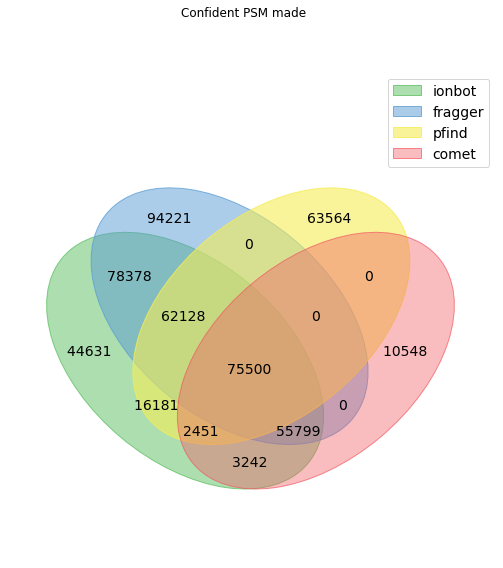

In [9]:
labels = venn.get_labels(setlist1)
fig, ax = venn.venn4(labels, names=['ionbot', 'fragger', 'pfind', 'comet'])
fig.suptitle("Confident PSM made")
fig.show()

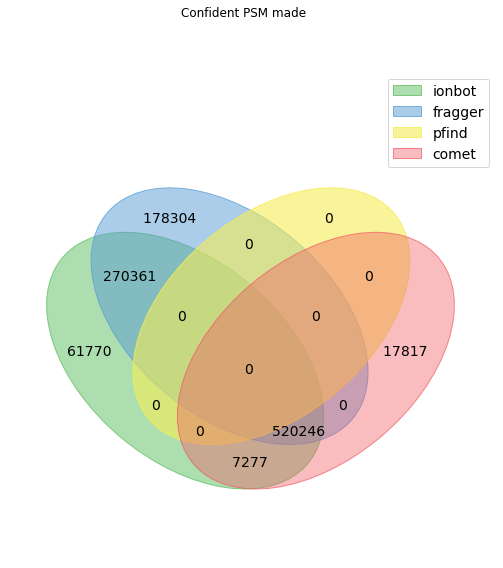

In [10]:
labels = venn.get_labels(setlist2)
fig, ax = venn.venn4(labels, names=['ionbot', 'fragger', 'pfind', 'comet'])
fig.suptitle("Confident PSM made")
fig.show()

In [11]:
def evalseq(row, SE="ionbot"):
    if row["{} Sequence".format(SE)] == row["Comet Raw Sequence"]:
        return True
    else:
        return False

In [12]:
def evalmod(row, SE="ionbot"):
    if pd.isna(row["comet_mods_formatted"]):
        if not pd.isna(row["{}_mods_formatted".format(SE)]): #If comet doesn't give mods but OSE does
            return "Newly modified"
        else:                                                #If both comet and OSE dont give mods
            return "Remains unmodified"
    else:
        if not pd.isna(row["{}_mods_formatted".format(SE)]): #If comet gives mods and OSE gives mods
            if row["{}_mods_formatted".format(SE)] == row["comet_mods_formatted"]:
                return "Same modifications"
            else:
                return "Different modifications"
        else:
            return "No longer modified"

In [13]:
PXD002516["ionbot_seq_eval"] = PXD002516.apply(evalseq, SE="ionbot", axis=1)
PXD002516["fragger_seq_eval"] = PXD002516.apply(evalseq, SE="Fragger", axis=1)
PXD002516["pfind_seq_eval"] = PXD002516.apply(evalseq, SE="pFind", axis=1)
PXD004010["ionbot_seq_eval"] = PXD004010.apply(evalseq, SE="ionbot", axis=1)
PXD004010["fragger_seq_eval"] = PXD004010.apply(evalseq, SE="Fragger", axis=1)
PXD004010["pfind_seq_eval"] = PXD004010.apply(evalseq, SE="pFind", axis=1)

In [14]:
PXD002516["ionbot_mods_eval"] = PXD002516.apply(evalmod, SE="ionbot", axis=1)
PXD002516["fragger_mods_eval"] = PXD002516.apply(evalmod, SE="fragger", axis=1)
PXD002516["pfind_mods_eval"] = PXD002516.apply(evalmod, SE="pfind", axis=1)
PXD004010["ionbot_mods_eval"] = PXD004010.apply(evalmod, SE="ionbot", axis=1)
PXD004010["fragger_mods_eval"] = PXD004010.apply(evalmod, SE="fragger", axis=1)
PXD004010["pfind_mods_eval"] = PXD004010.apply(evalmod, SE="pfind", axis=1)

==> welke spectra hebben confident PSM voor de search engines

# PXD002516

In [15]:
ionbotIR = PXD002516[PXD002516["ionbot Sequence"].notna()].shape[0] / 1878056
MSFraggerIR = PXD002516[PXD002516["Fragger Sequence"].notna()].shape[0] / 1878056
pFindIR = PXD002516[PXD002516["pFind Sequence"].notna()].shape[0] / 1878056
CometIR = PXD002516[PXD002516["Comet Sequence"].notna()].shape[0] / 1878056
print("ionbot Identification Rate: " + str(ionbotIR))
print("MSFragger Identification Rate: " + str(MSFraggerIR))
print("pFind Identification Rate: " + str(pFindIR))
print("Comet Identification Rate: " + str(CometIR))

ionbot Identification Rate: 0.18013839842901383
MSFragger Identification Rate: 0.19489621182754935
pFind Identification Rate: 0.11704869290372598
Comet Identification Rate: 0.07855995774353906


In [16]:
Allmatched = PXD002516[PXD002516["code"].str.startswith("1111-")]

In [17]:
Allmatched.to_csv("Allmatched.tsv")

In [18]:
codedict = {"1111-111111" : "Same for all 4", "1111-101010" : "pFind deviates", "1111-110100" : "Comet deviates", "1111-000111": "ionbot deviates", "1111-011001" : "MSFragger deviates", "1111-000100" : "MSFragger & pFind agree, ionbot and Comet differ", "1111-010010": "ionbot = pFind & MSFragger = Comet", "1111-000001" : "pFind and Comet agree, ionbot and MSFragger differ", "1111-010000" : "ionbot and pFind agree, MSFragger and Comet differ", "1111-000000" : "Different for all 4", "1111-001000" : "ionbot and Comet agree, MSFragger and pFind differ", "1111-100001" : "ionbot = MSFragger & pFind = Comet", "1111-000010":"MSFragger and Comet agree, pFind and ionbot differ", "1111-100000" : "ionbot and MSFragger agree, pFind and Comet differ", "1111-001100" : "ionbot = Comet & MSFragger = pFind"}

In [19]:
Allmatched.replace({"code" : codedict}, inplace=True)

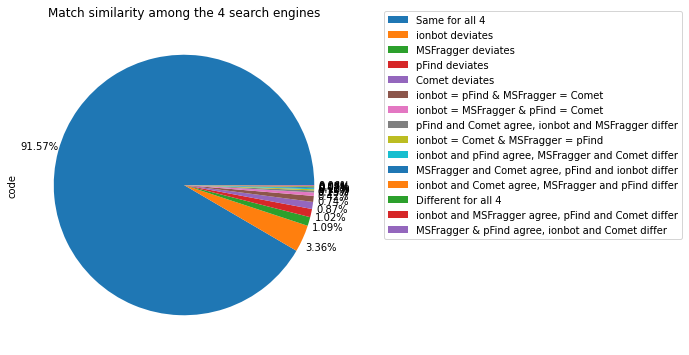

In [20]:
fig = plt.figure(figsize = (10,30))
ax = Allmatched["code"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', pctdistance=1.15)
ax.set_title("Match similarity among the 4 search engines")
ax
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=Allmatched["code"].value_counts().index)
fig.tight_layout()

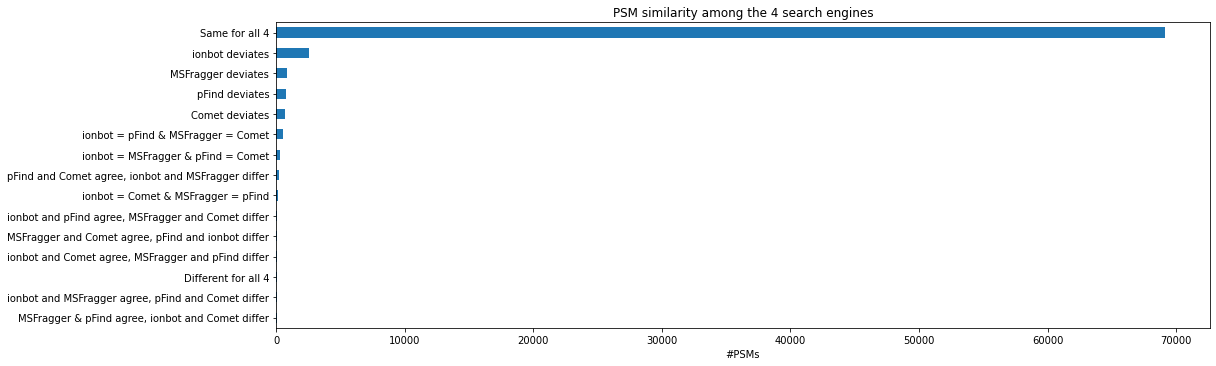

In [21]:
fig = plt.figure(figsize = (17,5))
ax = Allmatched["code"].value_counts().plot(kind="barh")
ax.set_title("PSM similarity among the 4 search engines")
ax.invert_yaxis()
fig.tight_layout()
plt.xlabel("#PSMs")
plt.show()

- Huge majority is the same PSM for all 4 search engines
- Interesting: you'd think Comet would deviate the most because most modifications can't be identified with Comet, but it actually deviates from the other three the least!

# Compare ionbot, MSFragger and pFind with Comet

## ionbot

In [22]:
#Get PSMs where ionbot differs from Comet
ionbotvcomet = Allmatched[Allmatched["code"].isin(["ionbot deviates", "MSFragger & pFind agree, ionbot and Comet differ", "Comet deviates", "ionbot = pFind & MSFragger = Comet", "pFind and Comet agree, ionbot and MSFragger differ", "ionbot and pFind agree, MSFragger and Comet differ", "Different for all 4", "ionbot = MSFragger & pFind = Comet", "MSFragger and Comet agree, pFind and ionbot differ", "ionbot and MSFragger agree, pFind and Comet differ"])]

In [23]:
ionbotvcomet.head()

,Unnamed: 0.1,Unnamed: 0,Spectrum File,Scan,charge,precursor_mass,ionbot Sequence,ionbot peptide mass,comet peptide mass,ionbot modifications,...,pFindID,CometID,Fragger PEP,code,ionbot_seq_eval,fragger_seq_eval,pfind_seq_eval,ionbot_mods_eval,fragger_mods_eval,pfind_mods_eval
14,14,14,131023_Sunil_PPT_Brain_A_01,10259.0,2.0,1489.73325,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110259.0LQGIVSWGSGCA...,131023_Sunil_PPT_Brain_A_0110259.0LQGIVSWGSGCA...,0.0000,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
20,20,20,131023_Sunil_PPT_Brain_A_01,10369.0,2.0,1489.73289,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110369.0LQGIVSWGSGCA...,131023_Sunil_PPT_Brain_A_0110369.0LQGIVSWGSGCA...,0.0002,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
31,31,31,131023_Sunil_PPT_Brain_A_01,10513.0,2.0,2266.00275,GAGQGPITEDMLCAGYLEGER,2265.98816,2208.9771,x|[914]Methylmalonylation[S],...,131023_Sunil_PPT_Brain_A_0110513.0SAYPGQITSNMF...,131023_Sunil_PPT_Brain_A_0110513.0SAYPGQITSNMF...,0.0023,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
40,40,40,131023_Sunil_PPT_Brain_A_01,10677.0,2.0,1489.73355,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110677.0LQGIVSWGSGCA...,131023_Sunil_PPT_Brain_A_0110677.0LQGIVSWGSGCA...,0.0215,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
51,51,51,131023_Sunil_PPT_Brain_A_01,10820.0,2.0,1489.72915,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110820.0LQGIVSWGSGCA...,131023_Sunil_PPT_Brain_A_0110820.0LQGIVSWGSGCA...,0.0266,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications


In [24]:
def which_is_it_then(row, ionbot=False, Fragger=False, pFind=False):
    if ionbot:
        if pd.isna(row["comet_mods_formatted"]):
            if not pd.isna(row["ionbot_mods_formatted"]):
                #Als comet geen modifications gaf en ionbot wel
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, now with modification(s)"
                else:
                    return "Different sequence with modification(s)"
            else: #Als zowel Comet als ionbot geen modifications geven
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"
        
        elif pd.isna(row["ionbot_mods_formatted"]):
            if not pd.isna(row["comet_mods_formatted"]):
                #Als ionbot geen modifications gaf en comet wel
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, no longer modified"
                else:
                    return "Different sequence, not modified"
            else: #Als zowel ionbot en Comet geen modificaties geven
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"

        else: #Als beide modificaties geven
            if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                if row["ionbot_mods_formatted"] == row["comet_mods_formatted"]:
                    return "ERROR"
                else:
                    return "Same sequence, different modifications"
            else:
                if row["ionbot_mods_formatted"] == row["comet_mods_formatted"]:
                    return "Different sequence, same modifications"
                else:
                    return "Different sequence, different modifications"
    
    elif Fragger:
        if pd.isna(row["comet_mods_formatted"]):
            if not pd.isna(row["fragger_mods_formatted"]):
                #Als comet geen modifications gaf en Fragger wel
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, now with modification(s)"
                else:
                    return "Different sequence with modification(s)"
            else: #Als zowel Comet als Fragger geen modifications geven
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"
        
        elif pd.isna(row["fragger_mods_formatted"]):
            if not pd.isna(row["comet_mods_formatted"]):
                #Als Fragger geen modifications gaf en comet wel
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, no longer modified"
                else:
                    return "Different sequence, not modified"
            else: #Als zowel Fragger en Comet geen modificaties geven
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"

        else: #Als beide modificaties geven
            if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                if row["fragger_mods_formatted"] == row["comet_mods_formatted"]:
                    return "ERROR"
                else:
                    return "Same sequence, different modifications"
            else:
                if row["fragger_mods_formatted"] == row["comet_mods_formatted"]:
                    return "Different sequence, same modifications"
                else:
                    return "Different sequence, different modifications"

    elif pFind:
        if pd.isna(row["comet_mods_formatted"]):
            if not pd.isna(row["pfind_mods_formatted"]):
                #Als comet geen modifications gaf en pFind wel
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, now with modification(s)"
                else:
                    return "Different sequence with modification(s)"
            else: #Als zowel Comet als pFind geen modifications geven
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"
        
        elif pd.isna(row["pfind_mods_formatted"]):
            if not pd.isna(row["comet_mods_formatted"]):
                #Als pFind geen modifications gaf en comet wel
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, no longer modified"
                else:
                    return "Different sequence, not modified"
            else: #Als zowel pFind en Comet geen modificaties geven
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"

        else: #Als beide modificaties geven
            if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                if row["pfind_mods_formatted"] == row["comet_mods_formatted"]:
                    return "ERROR"
                else:
                    return "Same sequence, different modifications"
            else:
                if row["pfind_mods_formatted"] == row["comet_mods_formatted"]:
                    return "Different sequence, same modifications"
                else:
                    return "Different sequence, different modifications"

In [25]:
ionbotvcomet["Evaluation"] = ionbotvcomet.progress_apply(which_is_it_then, ionbot=True, axis=1)

100%|██████████| 4587/4587 [00:00<00:00, 34916.25it/s]


In [26]:
ionbotvcomet.head()

,Unnamed: 0.1,Unnamed: 0,Spectrum File,Scan,charge,precursor_mass,ionbot Sequence,ionbot peptide mass,comet peptide mass,ionbot modifications,...,CometID,Fragger PEP,code,ionbot_seq_eval,fragger_seq_eval,pfind_seq_eval,ionbot_mods_eval,fragger_mods_eval,pfind_mods_eval,Evaluation
14,14,14,131023_Sunil_PPT_Brain_A_01,10259.0,2.0,1489.73325,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110259.0LQGIVSWGSGCA...,0.0000,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
20,20,20,131023_Sunil_PPT_Brain_A_01,10369.0,2.0,1489.73289,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110369.0LQGIVSWGSGCA...,0.0002,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
31,31,31,131023_Sunil_PPT_Brain_A_01,10513.0,2.0,2266.00275,GAGQGPITEDMLCAGYLEGER,2265.98816,2208.9771,x|[914]Methylmalonylation[S],...,131023_Sunil_PPT_Brain_A_0110513.0SAYPGQITSNMF...,0.0023,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
40,40,40,131023_Sunil_PPT_Brain_A_01,10677.0,2.0,1489.73355,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110677.0LQGIVSWGSGCA...,0.0215,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
51,51,51,131023_Sunil_PPT_Brain_A_01,10820.0,2.0,1489.72915,LQGIVSWGSNCAQK,1489.73472,1432.7133,10|Gly->Asn[G],...,131023_Sunil_PPT_Brain_A_0110820.0LQGIVSWGSGCA...,0.0266,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"


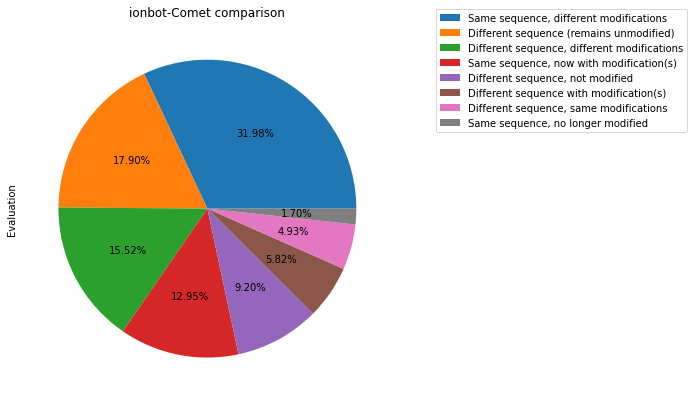

In [27]:
fig = plt.figure(figsize = (10,50))
ax = ionbotvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%')
ax.set_title("ionbot-Comet comparison")
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=ionbotvcomet["Evaluation"].value_counts().index)
fig.tight_layout()

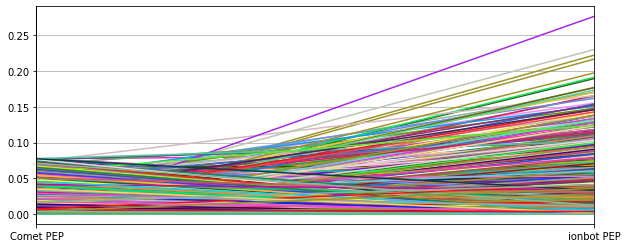

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
parallel_coordinates(ionbotvcomet,"ionbot Sequence",["Comet PEP", "ionbot PEP"])
ax.legend_.remove()

Doesn't look great, if you see boxplots you see that box is lower than Comet but way more extreme outliers which is reflected here

In [29]:
res = stats.wilcoxon(x=ionbotvcomet["Comet PEP"], y=ionbotvcomet["ionbot PEP"], alternative='greater', nan_policy="raise")
print(res)

WilcoxonResult(statistic=7663906.0, pvalue=2.339789432060163e-158)


## Fragger

In [30]:
#Filter PSMs where Comet and MSFragger differ
fraggervcomet = Allmatched[Allmatched["code"].isin(["MSFragger deviates", "pFind and Comet agree, ionbot and MSFragger differ", "Comet deviates", "ionbot and pFind agree, MSFragger and Comet differ", "ionbot and Comet agree, MSFragger and pFind differ", "ionbot = MSFragger & pFind = Comet", "Different for all 4", "ionbot = Comet & MSFragger = pFind", "ionbot and MSFragger agree, pFind and Comet differ", "MSFragger & pFind agree, ionbot and Comet differ"])]

In [31]:
fraggervcomet["Evaluation"] = fraggervcomet.progress_apply(which_is_it_then, Fragger = True, axis=1)

100%|██████████| 2410/2410 [00:00<00:00, 25862.15it/s]


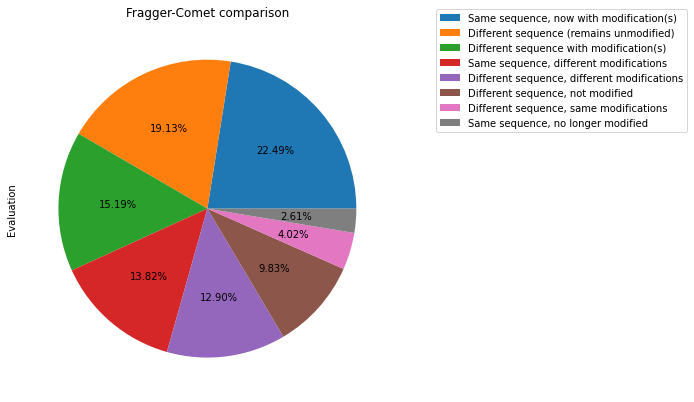

In [32]:
fig = plt.figure(figsize = (10,50))
ax = fraggervcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%')
ax.set_title("Fragger-Comet comparison")
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=fraggervcomet["Evaluation"].value_counts().index)
fig.tight_layout()

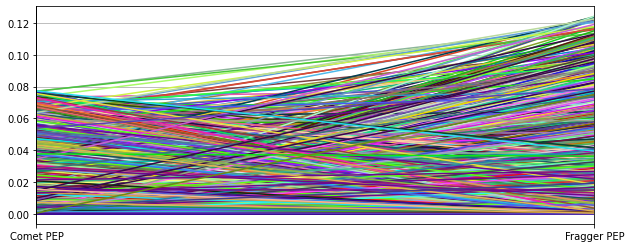

In [33]:
fig, ax = plt.subplots(figsize=(10,4))
parallel_coordinates(fraggervcomet,"Fragger Sequence",["Comet PEP", "Fragger PEP"])
ax.legend_.remove()

In [34]:
res = stats.wilcoxon(x=fraggervcomet["Comet PEP"], y=fraggervcomet["Fragger PEP"], alternative="less")
print(res)

WilcoxonResult(statistic=1398585.0, pvalue=0.056841883395809915)


LESS GOOD!!

## pFind

Oke dus geen PEP voor pFind ==> alles behalve de paired test

Daarna: filter PSMs op zij die verschillen tussen ionbot, Fragger en Comet en doe dan ook zo een grafiek gelijk bij accuracy_check

Daarna: mss niet filteren en echt alle PSMs checken (checkt ook of PEP-test relevant is)

In [35]:
#Filter PSMs where Comet and pFind differ
pfindvcomet = Allmatched[Allmatched["code"].isin(["pFind deviates","Comet deviates", "ionbot and pFind agree, MSFragger and Comet differ", "Different for all 4", "ionbot and MSFragger agree, pFind and Comet differ", "MSFragger & pFind agree, ionbot and Comet differ", "ionbot = pFind & MSFragger = Comet", "ionbot and Comet agree, MSFragger and pFind differ", "MSFragger and Comet agree, pFind and ionbot differ", "ionbot = Comet & MSFragger = pFind"])]

In [36]:
pfindvcomet["Evaluation"] = pfindvcomet.progress_apply(which_is_it_then, pFind=True, axis=1)

100%|██████████| 2497/2497 [00:00<00:00, 26581.74it/s]


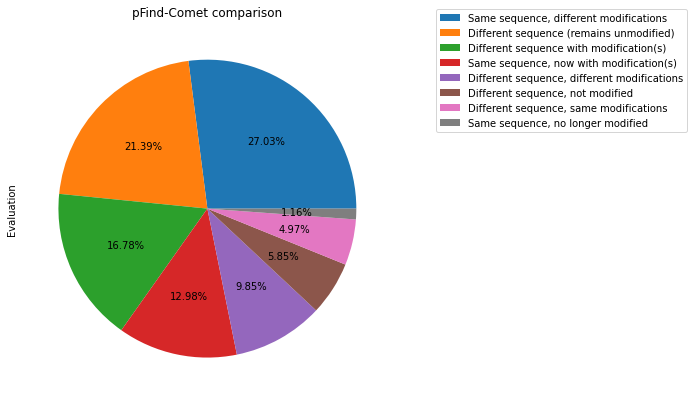

In [37]:
fig = plt.figure(figsize = (10,50))
ax = pfindvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%')
ax.set_title("pFind-Comet comparison")
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=pfindvcomet["Evaluation"].value_counts().index)
fig.tight_layout()

## Combine the which is it then plots

In [38]:
colors={'Same sequence, different modifications': 'cyan',
'Different sequence (remains unmodified)': "orange",
"Different sequence, different modifications": "purple",
"Different sequence, not modified" : "red",
'Same sequence, now with modification(s)' : "brown",
'Different sequence with modification(s)' : "pink",
'Different sequence, same modifications':"green",
"Same sequence, no longer modified": "grey"}

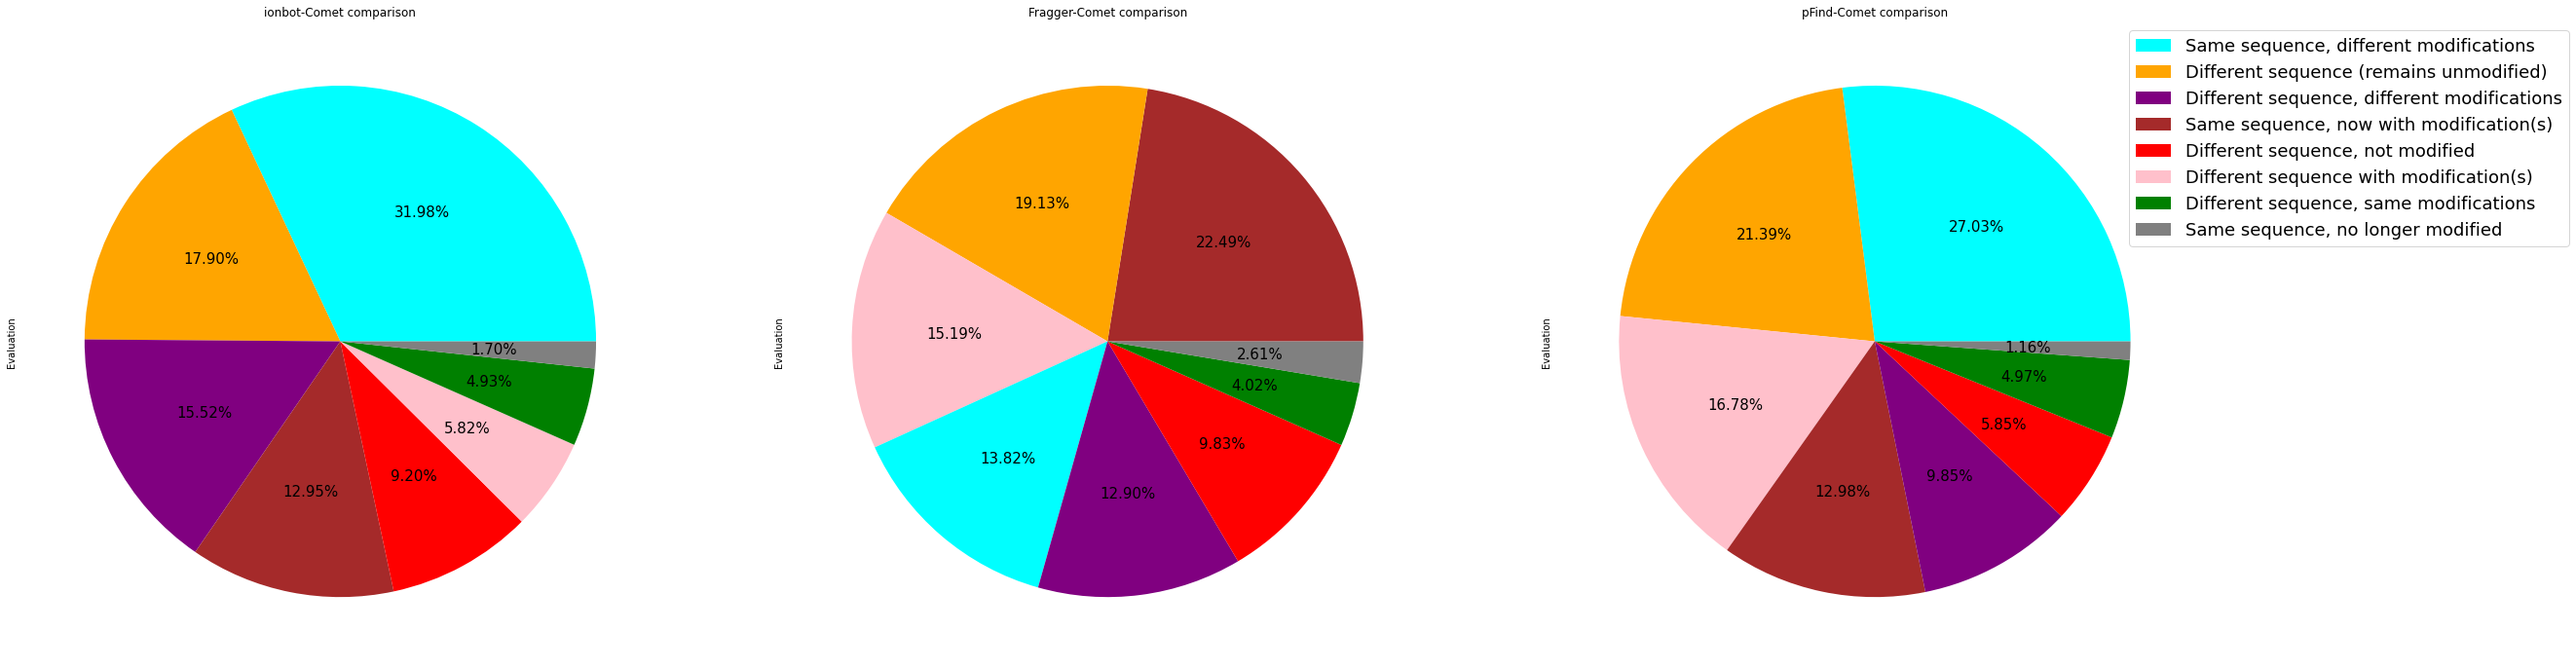

In [39]:
fig, ax = plt.subplots(1,3)
ax1 = ionbotvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[0], colors=[colors[v] for v in ionbotvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax1.set_title("ionbot-Comet comparison")
ax2 = fraggervcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[1], colors=[colors[v] for v in fraggervcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax2.set_title("Fragger-Comet comparison")
ax3 = pfindvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[2], colors=[colors[v] for v in pfindvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax3.set_title("pFind-Comet comparison")
ax1.legend(labels = ionbotvcomet["Evaluation"].value_counts().keys(), bbox_to_anchor=(4,1), prop={'size': 18})
fig.set_size_inches(40,50)


- quite different between all three
- counter-intuitively, a lot of the changes is different sequence with no change in modifications, or even with less modifications than closed search PSM (okergeel, rood, grijs)
- ionbot identifies same sequence, different modifications a lot, which makes sense, but others don't do this as much (the PSMs where this happens are also most of the time where ionbot deviates)
- Fragger identifies, same sequence, now with modifications a lot, which makes sense, but others don't do this as much ==> if you check these, this is always a very small modification added (makes sense), like deamidation, amidation, other mods wiht mass of +/- 1 m/z 

# PEP comparison for the scans where ionbot, MSFragger and Comet PSMs are different

In [40]:
#Scans where ionbot, pFind and Comet differ
PEPcheck = Allmatched[Allmatched["code"].isin(["ionbot and pFind agree, MSFragger and Comet differ", "Different for all 4", "MSFragger & pFind agree, ionbot and Comet differ", "pFind and Comet agree, ionbot and MSFragger differ"])]

Text(11.75, 0.5, 'PEP')

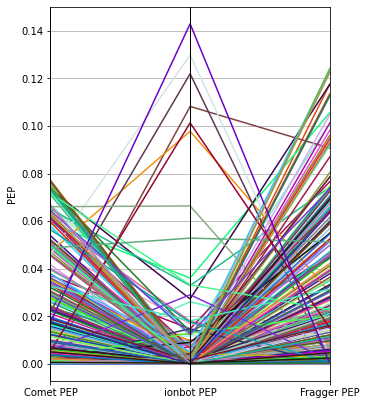

In [41]:
fig, ax = plt.subplots(figsize=(5,6))
parallel_coordinates(PEPcheck,"Scan",["Comet PEP", "ionbot PEP", "Fragger PEP"])
ax.legend_.remove()
fig.tight_layout()
fig.subplots_adjust(top=0.93)
ax.set_ylabel("PEP")

In [42]:
stats.kruskal(PEPcheck["Comet PEP"], PEPcheck["ionbot PEP"], PEPcheck["Fragger PEP"])

KruskalResult(statistic=227.63322461525385, pvalue=3.7159796405517064e-50)

In [43]:
sp.posthoc_dunn([PEPcheck["Comet PEP"], PEPcheck["ionbot PEP"], PEPcheck["Fragger PEP"]], p_adjust="bonferroni")

,1,2,3
1,1.000000e+00,4.333045e-44,9.620159e-02
2,4.333045e-44,1.000000e+00,5.604557e-32
3,9.620159e-02,5.604557e-32,1.000000e+00


# PEP check for spectra where PSMs of ionbot, Fragger and Comet are the same (validation)

In [44]:
#Scans where PSMs of ionbot, Fragger, Comet are the same
PEPcheckval = Allmatched[Allmatched["code"].isin(["Same for all 4", "pFind deviates"])]
#Get sample (if you don't theres too many rows in parallel coordinates plot, which makes it hard to discern pattern)
PEPcheckval_sample = PEPcheckval.sample(1000)

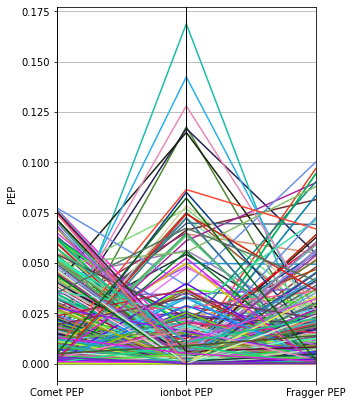

In [45]:
fig, ax = plt.subplots(figsize=(5,6))
parallel_coordinates(PEPcheckval_sample,"Scan",["Comet PEP", "ionbot PEP", "Fragger PEP"])
ax.legend_.remove()
ax.set_ylabel("PEP")
fig.tight_layout()
fig.subplots_adjust(top=0.93)

In [46]:
stats.kruskal(PEPcheckval["Comet PEP"], PEPcheckval["ionbot PEP"], PEPcheckval["Fragger PEP"])

KruskalResult(statistic=13245.865902725534, pvalue=0.0)

Post-hoc:

In [47]:
sp.posthoc_dunn([PEPcheckval["Comet PEP"], PEPcheckval["ionbot PEP"], PEPcheckval["Fragger PEP"]], p_adjust="bonferroni")

,1,2,3
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0


<Axes: >

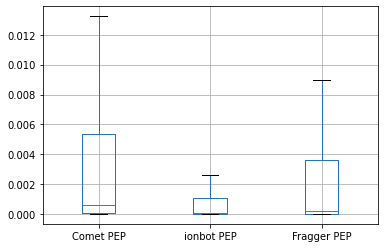

In [48]:
PEPcheckval[["Comet PEP","ionbot PEP","Fragger PEP"]].boxplot(showfliers=False)

Above plot but for all PSMs

Text(0, 0.5, 'PEP')

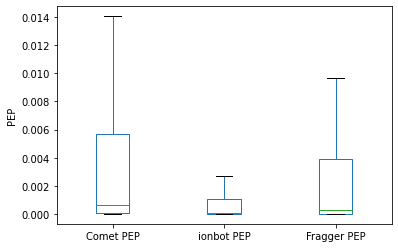

In [49]:
fig, ax = plt.subplots(figsize=(6,4))
Allmatched[["Comet PEP","ionbot PEP","Fragger PEP"]].boxplot(showfliers=False, grid=False)
# plt.suptitle("PEP values for all PSMs", size=12, fontweight="bold")
ax.set_ylabel("PEP")
# fig.tight_layout()


<Axes: >

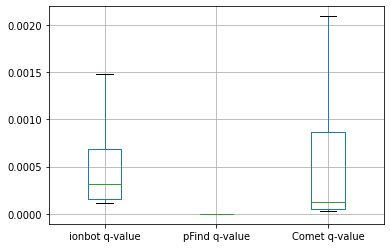

In [50]:
PEPcheckval[["ionbot q-value", "pFind q-value", "Comet q-value"]].boxplot(showfliers=False)

Bin PEP's for each Search engine?  And then compare the bins in which the PSMs are found?

## Binning?

In [51]:
Allmatched["ionbot PEP binned"] = pd.cut(Allmatched["ionbot PEP"], bins=(0, 0.01405, 0.0281, 0.04215, 0.0562, 0.07025, 0.0843, 0.09835, 0.1124, 0.12645, 0.1405, 0.15455, 0.1686,0.18265,0.1967,0.21075,0.2248,0.23885,0.2529,0.26695,0.281), labels=[i+1 for i in range(20)], include_lowest=True)

In [52]:
Allmatched["Fragger PEP binned"] = pd.cut(Allmatched["Fragger PEP"], bins=(0, 0.00625, 0.0125, 0.01875, 0.025, 0.03125, 0.0375, 0.04375, 0.05, 0.05625, 0.0625, 0.06875, 0.075, 0.08125,0.0875,0.09375,0.1,0.10625,0.1125,0.11875,0.125), labels=[i+1 for i in range(20)], include_lowest=True)

In [53]:
Allmatched["Comet PEP binned"] = pd.cut(Allmatched["Comet PEP"], bins=(0,0.00385,0.0077,0.01155,0.0154,0.01925,0.0231,0.02695,0.0308,0.03465,0.0385,0.04235,0.0462,0.05005,0.0539,0.05775,0.0616,0.06545,0.0693,0.07315,0.077), labels=[i+1 for i in range(20)], include_lowest=True)

In [54]:
PEPcheckval_bin = Allmatched[Allmatched["code"].isin(["Same for all 4", "pFind deviates"])]
PEPcheckval_sample_bin = PEPcheckval_bin.sample(1000)

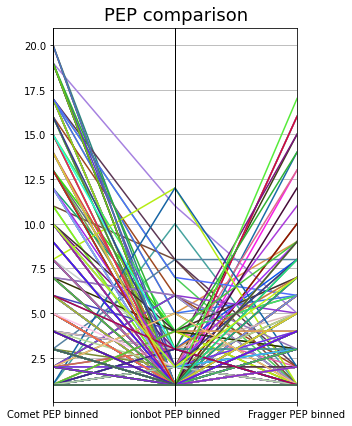

In [55]:
fig, ax = plt.subplots(figsize=(5,6))
parallel_coordinates(PEPcheckval_sample_bin,"Scan",["Comet PEP binned", "ionbot PEP binned", "Fragger PEP binned"])
plt.suptitle("PEP comparison", size=18)
ax.legend_.remove()
fig.tight_layout()
fig.subplots_adjust(top=0.93)

## Upsetplots

In [56]:
PXD002516.head()

,Unnamed: 0.1,Unnamed: 0,Spectrum File,Scan,charge,precursor_mass,ionbot Sequence,ionbot peptide mass,comet peptide mass,ionbot modifications,...,pFindID,CometID,Fragger PEP,code,ionbot_seq_eval,fragger_seq_eval,pfind_seq_eval,ionbot_mods_eval,fragger_mods_eval,pfind_mods_eval
0,0,0,131023_Sunil_PPT_Brain_A_01,10006.0,2.0,1158.62156,LAVNMVPFPR,1158.62191,NaN,5|[35]oxidation[M],...,131023_Sunil_PPT_Brain_A_0110006.0LAVNMVPFPR['...,NaN,0.0479,1110-110100,False,False,False,Newly modified,Newly modified,Newly modified
1,1,1,131023_Sunil_PPT_Brain_A_01,10011.0,3.0,1832.88472,TYFPHFDLSHGSAQVK,1832.88456,NaN,NaN,...,131023_Sunil_PPT_Brain_A_0110011.0TYFPHFDLSHGS...,NaN,0.0003,1110-110100,False,False,False,Remains unmodified,Remains unmodified,Remains unmodified
2,2,2,131023_Sunil_PPT_Brain_A_01,10039.0,2.0,1489.73264,LQGIVSWGSGCAQK,1489.73473,1432.7133,11|[4]carbamidomethyl[C],...,131023_Sunil_PPT_Brain_A_0110039.0LQGIVSWGSGCA...,131023_Sunil_PPT_Brain_A_0110039.0LQGIVSWGSGCA...,0.0000,1111-111111,True,True,True,Same modifications,Same modifications,Same modifications
3,3,3,131023_Sunil_PPT_Brain_A_01,10045.0,3.0,1832.88314,TYFPHFDLSHGSAQVK,1832.88456,NaN,NaN,...,131023_Sunil_PPT_Brain_A_0110045.0TYFPHFDLSHGS...,NaN,0.0027,1110-110100,False,False,False,Remains unmodified,Remains unmodified,Remains unmodified
4,4,4,131023_Sunil_PPT_Brain_A_01,10051.0,2.0,875.51060,IFLQDIK,875.51164,NaN,NaN,...,131023_Sunil_PPT_Brain_A_0110051.0IFLQDIKnan,NaN,0.0453,1110-110100,False,False,False,Remains unmodified,Remains unmodified,Remains unmodified


## All scans taken into account

In [57]:
ionbot = list(PXD002516["ionbotID"])
ionbot = [x for x in ionbot if str(x) != 'nan']
fragger = list(PXD002516["FraggerID"])
fragger = [x for x in fragger if str(x) != 'nan']
pfind = list(PXD002516["pFindID"])
pfind = [x for x in pfind if str(x) != 'nan']
comet = list(PXD002516["CometID"])
comet = [x for x in comet if str(x) != 'nan']

In [58]:
from collections import Counter
Counter(ionbot).most_common(3)

[("131023_Sunil_PPT_Brain_A_0110006.0LAVNMVPFPR['oxidation']", 1),
 ('131023_Sunil_PPT_Brain_A_0110011.0TYFPHFDLSHGSAQVKnan', 1),
 ("131023_Sunil_PPT_Brain_A_0110039.0LQGIVSWGSGCAQK['carbamidomethyl']", 1)]

In [59]:
allscans = upsetplot.from_contents({'ionbot': ionbot, 'MSFragger': fragger, 'pFind': pfind, 'Comet': comet})

<Figure size 720x576 with 0 Axes>

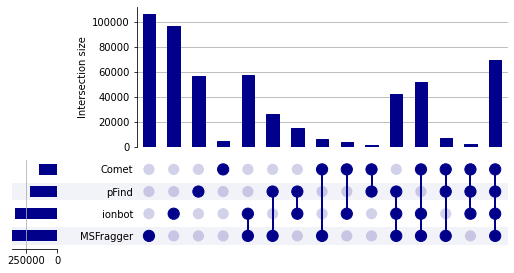

In [60]:
plt.figure(figsize=(10,8))
ax_dict = upsetplot.UpSet(allscans, subset_size="count", facecolor="darkblue", show_counts=False).plot()

## Only scans were all 4 search engines make a PSM

In [61]:
ionbotAllmatched = list(Allmatched["ionbotID"])
ionbotAllmatched = [x for x in ionbotAllmatched if str(x) != 'nan']
fraggerAllmatched = list(Allmatched["FraggerID"])
fraggerAllmatched = [x for x in fraggerAllmatched if str(x) != 'nan']
pfindAllmatched = list(Allmatched["pFindID"])
pfindAllmatched = [x for x in pfindAllmatched if str(x) != 'nan']
cometAllmatched = list(Allmatched["CometID"])
cometAllmatched = [x for x in cometAllmatched if str(x) != 'nan']

In [62]:
from collections import Counter
Counter(ionbotAllmatched).most_common(3)

[("131023_Sunil_PPT_Brain_A_0110039.0LQGIVSWGSGCAQK['carbamidomethyl']", 1),
 ("131023_Sunil_PPT_Brain_A_0110072.0VCNYVSWIK['carbamidomethyl']", 1),
 ("131023_Sunil_PPT_Brain_A_0110149.0LQGIVSWGSGCAQK['carbamidomethyl']", 1)]

In [63]:
allmatchedplot = upsetplot.from_contents({'ionbot':ionbotAllmatched, 'MSFragger': fraggerAllmatched, "pFind":pfindAllmatched, "Comet":cometAllmatched })

<Figure size 720x576 with 0 Axes>

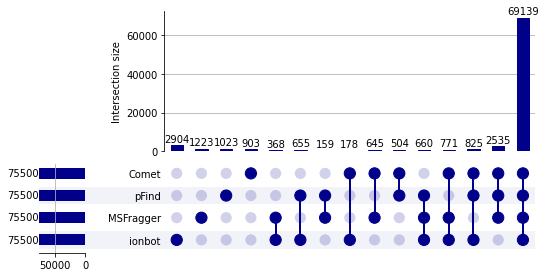

In [64]:
plt.figure(figsize=(10,8))
ax_dict = upsetplot.UpSet(allmatchedplot, subset_size="count", facecolor="darkblue", show_counts=True).plot()

# Same as above but not all 4 same

In [65]:
notall4 = Allmatched[Allmatched["code"] != "Same for all 4"]

In [66]:
ionbotnotall4 = list(notall4["ionbotID"])
ionbotnotall4 = [x for x in ionbotnotall4 if str(x) != 'nan']
fraggernotall4 = list(notall4["FraggerID"])
fraggernotall4 = [x for x in fraggernotall4 if str(x) != 'nan']
pfindnotall4 = list(notall4["pFindID"])
pfindnotall4 = [x for x in pfindnotall4 if str(x) != 'nan']
cometnotall4 = list(notall4["CometID"])
cometnotall4 = [x for x in cometnotall4 if str(x) != 'nan']

In [67]:
notall4plot = upsetplot.from_contents({'ionbot':ionbotnotall4, 'MSFragger': fraggernotall4, "pFind":pfindnotall4, "Comet":cometnotall4 })

<Figure size 720x576 with 0 Axes>

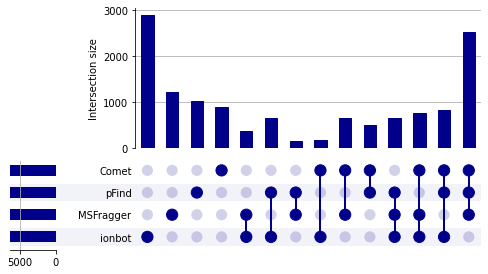

In [68]:
plt.figure(figsize=(10,8))
ax_dict = upsetplot.UpSet(notall4plot, subset_size="count", facecolor="darkblue").plot()

Most of the times this is because of substitutions found

## Evaluation should go in bar plot

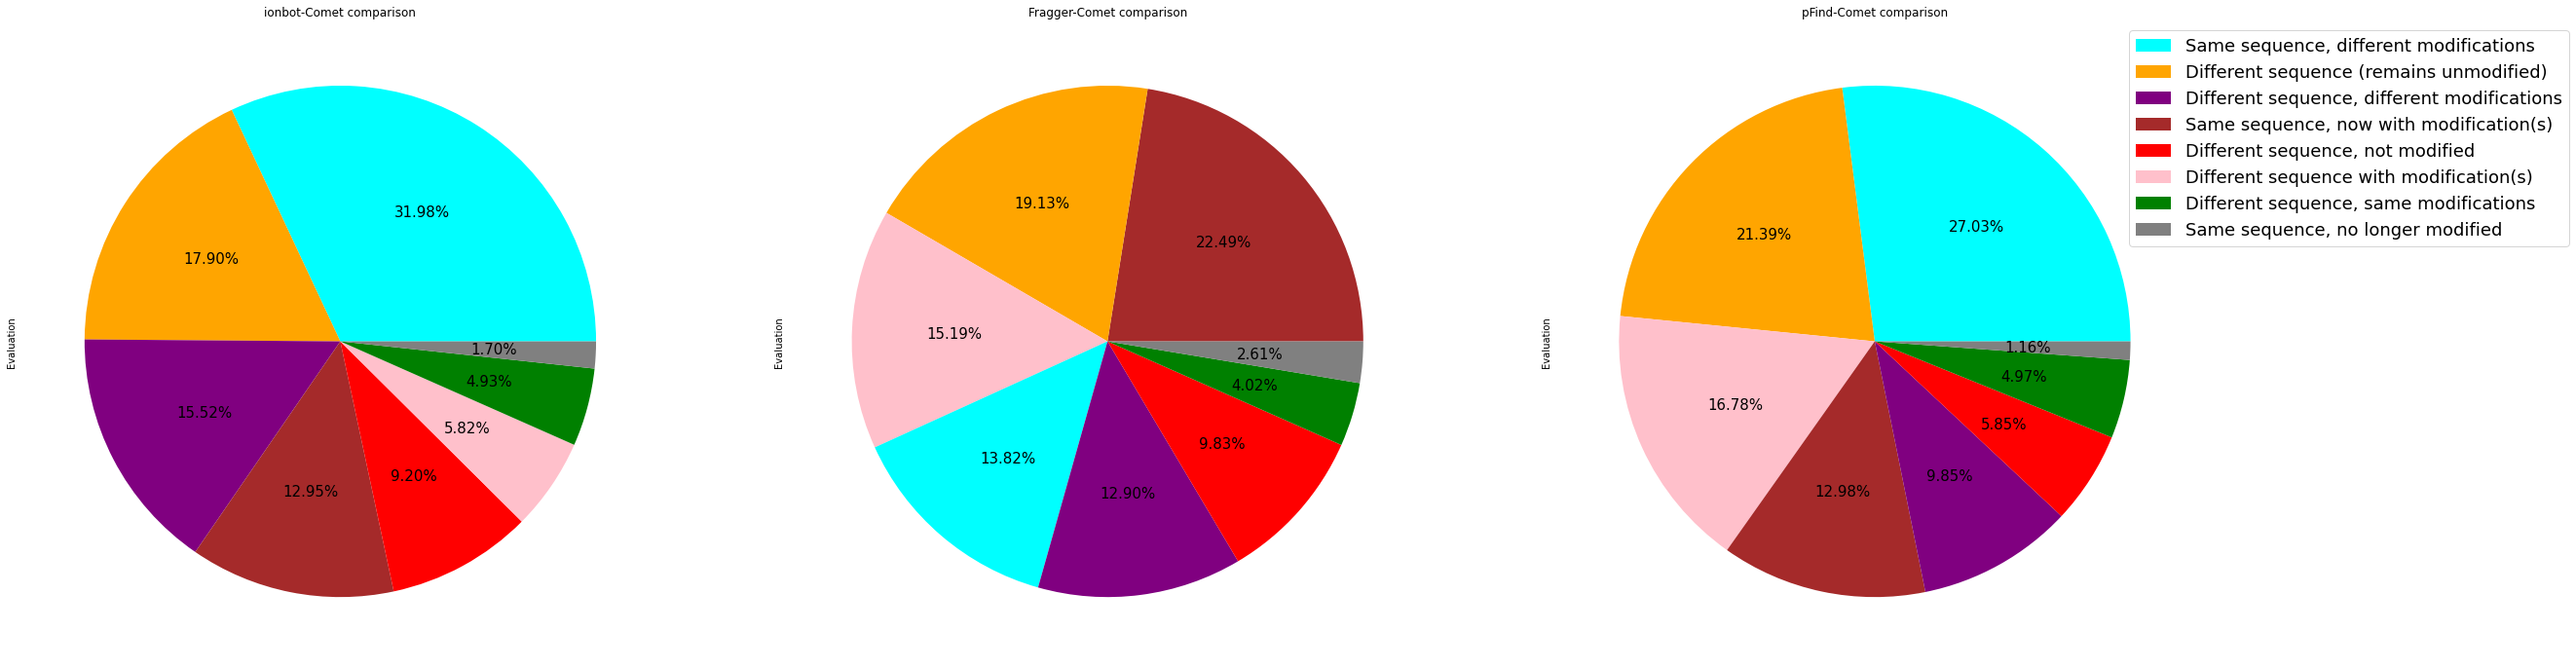

In [69]:
fig, ax = plt.subplots(1,3)
ax1 = ionbotvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[0], colors=[colors[v] for v in ionbotvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax1.set_title("ionbot-Comet comparison")
ax2 = fraggervcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[1], colors=[colors[v] for v in fraggervcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax2.set_title("Fragger-Comet comparison")
ax3 = pfindvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[2], colors=[colors[v] for v in pfindvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax3.set_title("pFind-Comet comparison")
ax1.legend(labels = ionbotvcomet["Evaluation"].value_counts().keys(), bbox_to_anchor=(4,1), prop={'size': 18})
fig.set_size_inches(40,50)

In [70]:
ionbotwhich = ionbotvcomet.groupby(["ionbot_seq_eval", "ionbot_mods_eval"])["ionbotID"].count()
fraggerwhich = fraggervcomet.groupby(["fragger_seq_eval", "fragger_mods_eval"])["FraggerID"].count()
pfindwhich = pfindvcomet.groupby(["pfind_seq_eval", "pfind_mods_eval"])["pFindID"].count()

Maak met die data bar plots ala powerpoint

In [71]:
iw = ionbotwhich.reset_index()
fw = fraggerwhich.reset_index()
pw = pfindwhich.reset_index()

In [72]:
fw

,fragger_seq_eval,fragger_mods_eval,FraggerID
0,False,Different modifications,311
1,False,Newly modified,366
2,False,No longer modified,237
3,False,Remains unmodified,461
4,False,Same modifications,97
5,True,Different modifications,333
6,True,Newly modified,542
7,True,No longer modified,63


In [73]:
iw["Relative occurrence"] = (iw["ionbotID"] /iw["ionbotID"].sum()).round(3)
fw["Relative occurrence"] = (fw["FraggerID"] /fw["FraggerID"].sum()).round(3)
pw["Relative occurrence"] = (pw["pFindID"]/pw["pFindID"].sum()).round(3)

In [74]:
iw.rename(columns={"ionbotID":"ID", "ionbot_mods_eval":"ModsEval", "ionbot_seq_eval":"SeqEval"}, inplace=True)
fw.rename(columns={"FraggerID":"ID", "fragger_mods_eval":"ModsEval", "fragger_seq_eval":"SeqEval"}, inplace=True)
pw.rename(columns={"pFindID":"ID", "pfind_mods_eval": "ModsEval", "pfind_seq_eval":"SeqEval"}, inplace=True)


In [75]:
iw["SE"] = "ionbot"
fw["SE"] = "MSFragger"
pw["SE"] = "pFind"

In [76]:
data = pd.concat([iw, fw, pw])

In [77]:
seqevaltrue = data[data["SeqEval"] == True]
seqevalfalse = data[data["SeqEval"] == False]

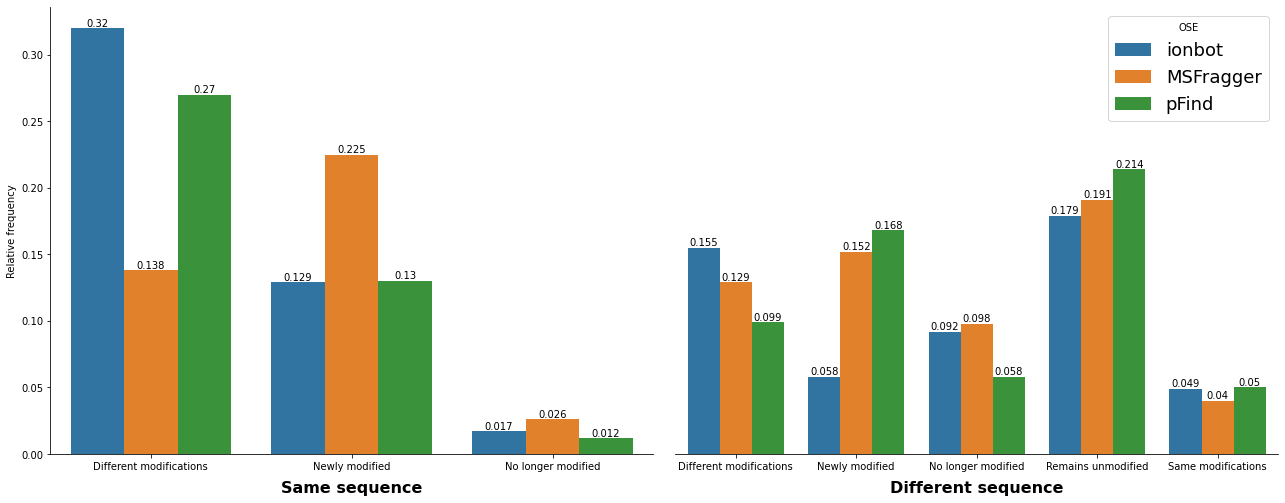

In [78]:
fig, axes = plt.subplots(1,2,sharey=True, figsize=(18,7))
a = sns.barplot(data=seqevaltrue, x="ModsEval", y="Relative occurrence", hue="SE", ax=axes[0])
b = sns.barplot(data = seqevalfalse, x="ModsEval", y="Relative occurrence", hue="SE", ax=axes[1])
axes[0].set_ylabel("Relative frequency")
axes[1].set_ylabel("Relative frequency")
axes[1].yaxis.set_tick_params(labelbottom=True)
axes[0].xaxis.label.set_visible(False)
axes[1].xaxis.label.set_visible(False)
axes[0].set_title("Same sequence", fontweight="bold", fontsize=16, y=-.10)
axes[1].set_title("Different sequence", fontweight="bold", fontsize=16, y=-0.10)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

#axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
#axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
# axes[1].axes.get_yaxis().set_ticks([])
axes[1].axes.get_yaxis().set_visible(False)
axes[0].get_legend().remove()
for container in axes[0].containers:
    axes[0].bar_label(container)
for container in axes[1].containers:
    axes[1].bar_label(container)
plt.legend(prop={'size': 18}, title="OSE", loc=1)
# fig.suptitle("OSE PSMs compared to Comet PSMs", fontsize=20, fontweight="bold")
fig.tight_layout()

In [79]:
ionbotvcomet.to_csv("ionbotvcomet.tsv", sep="\t")
fraggervcomet.to_csv("fraggervcomet.tsv", sep="\t")
pfindvcomet.to_csv("pfindvcomet.tsv", sep="\t")

# Q-value plots

In [80]:
PXD002516.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Spectrum File', 'Scan', 'charge',
       'precursor_mass', 'ionbot Sequence', 'ionbot peptide mass',
       'comet peptide mass', 'ionbot modifications',
       'ionbot unexpected modifications', 'ionbot q-value', 'ionbot PEP',
       'Fragger Sequence', 'Fragger Modified Sequence', 'Fragger Probability',
       'Fragger modifications', 'Fragger unexpected modifications',
       'MSFragger Localization', 'pFind Sequence', 'pFind Modification',
       'pFind q-value', 'Comet Sequence', 'Comet q-value', 'Comet PEP',
       'MSFragger Peptide Mass', 'pFind Peptide Mass', 'ionbot proteins',
       'comet proteins', 'fragger proteins', 'pfind proteins',
       'Comet Raw Sequence', 'ionbot_mods_formatted', 'all_fragger_mods',
       'fragger_mods_formatted', 'pfind_mods_formatted',
       'comet_mods_formatted', 'ionbotID', 'FraggerID', 'pFindID', 'CometID',
       'Fragger PEP', 'code', 'ionbot_seq_eval', 'fragger_seq_eval',
       'pfind_seq_eval', 'i

In [81]:
qvalues_fragger = pd.read_csv("/home/robbe/ionbot/Percolator/MSFragger_q/percolator.target.psms.txt", sep="\t")
qvalues_fragger = qvalues_fragger[qvalues_fragger["percolator q-value"] < 0.01]

In [82]:
qvalues = PXD002516.filter(like="q-value", axis="columns")
qvalues["MSFragger q-value"] = qvalues_fragger["percolator q-value"]

In [83]:
qvalues

,ionbot q-value,pFind q-value,Comet q-value,MSFragger q-value
0,0.00296,0.0,NaN,0.000014
1,0.00296,0.0,NaN,0.000014
2,0.00296,0.0,0.000048,0.000014
3,0.00296,0.0,NaN,0.000014
4,0.00296,0.0,NaN,0.000014
...,...,...,...,...
506638,NaN,NaN,0.009972,NaN
506639,NaN,NaN,0.009978,NaN
506640,NaN,NaN,0.009985,NaN
506641,NaN,NaN,0.009997,NaN


Text(0.5, 0, 'FDR threshold')

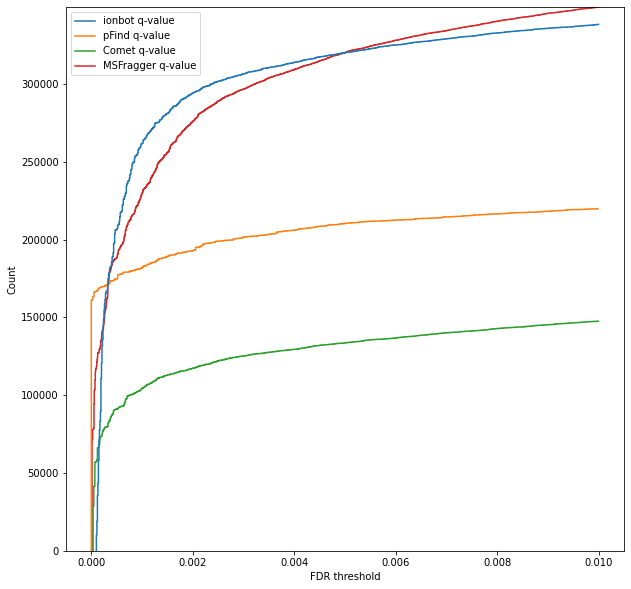

In [84]:
fig, ax = plt.subplots(figsize=(10,10))
sns.ecdfplot(data=qvalues, ax=ax, stat="count")
ax.set_xlabel("FDR threshold")

In [85]:
PXD002516.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Spectrum File', 'Scan', 'charge',
       'precursor_mass', 'ionbot Sequence', 'ionbot peptide mass',
       'comet peptide mass', 'ionbot modifications',
       'ionbot unexpected modifications', 'ionbot q-value', 'ionbot PEP',
       'Fragger Sequence', 'Fragger Modified Sequence', 'Fragger Probability',
       'Fragger modifications', 'Fragger unexpected modifications',
       'MSFragger Localization', 'pFind Sequence', 'pFind Modification',
       'pFind q-value', 'Comet Sequence', 'Comet q-value', 'Comet PEP',
       'MSFragger Peptide Mass', 'pFind Peptide Mass', 'ionbot proteins',
       'comet proteins', 'fragger proteins', 'pfind proteins',
       'Comet Raw Sequence', 'ionbot_mods_formatted', 'all_fragger_mods',
       'fragger_mods_formatted', 'pfind_mods_formatted',
       'comet_mods_formatted', 'ionbotID', 'FraggerID', 'pFindID', 'CometID',
       'Fragger PEP', 'code', 'ionbot_seq_eval', 'fragger_seq_eval',
       'pfind_seq_eval', 'i

In [86]:
ionbotq = PXD002516.sort_values("ionbot q-value", ascending=True)
ionbot70000 = set(ionbotq.iloc[:50000].index)
pfindq = PXD002516.sort_values("pFind q-value", ascending=True)
pfind70000 = set(pfindq.iloc[:50000].index)
cometq = PXD002516.sort_values("Comet q-value", ascending=True)
comet70000 = set(cometq.iloc[:50000].index)

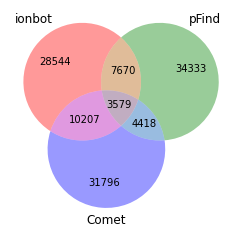

In [87]:
from matplotlib_venn import venn3
venn3(subsets=[ionbot70000, pfind70000, comet70000], set_labels=('ionbot', 'pFind', 'Comet'))